<div style="margin: auto;">
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/5/58/Seattle_Center_as_night_falls.jpg/1280px-Seattle_Center_as_night_falls.jpg" width=33%> </img>
</div>



### 1. Preparation of the problem



In [ ]:
# Installation of optuna and catboost packages, necessary for modeling.
!pip install optuna
!pip install catboost
!pip install shap

#### 1.1 Importing Libraries


In [ ]:
import pandas as pd
import numpy as np
import re
import plotly.express as px
import seaborn as sns
import optuna

from numpy import mean
from matplotlib import pyplot as plt
from pathlib import Path

from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer, TransformedTargetRegressor
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, KBinsDiscretizer, OneHotEncoder, MinMaxScaler, FunctionTransformer, RobustScaler, PowerTransformer,PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import Pool, CatBoostRegressor
from sklearn.model_selection import cross_validate, RepeatedKFold, KFold, cross_val_score
from sklearn.metrics import make_scorer, r2_score, mean_squared_error
from sklearn.feature_selection import VarianceThreshold
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.model_selection import train_test_split,validation_curve

import warnings
warnings.filterwarnings('ignore')

#### 1.2 Loading data

In [ ]:
# Data import
path = Path.cwd().joinpath('data').joinpath('data_maison.csv')
df = pd.read_csv(path, sep = ";")

# Formatting and processing of the "date" column.
df['date'] = pd.to_datetime(df['date'], format = '%Y%m%dT%H%M%S')
df['annee'] = df['date'].apply(lambda data :data.year)
df['mois'] = df['date'].apply(lambda data :data.month)
df = df.drop(['date'], axis = 1)

# Split the dataset into a training sample and a sample
# validation while setting aside the data corresponding to the "file to
# render" to evaluate the performance of our model.
data_train_validation = df[df["Ech"] != 0]
data_train_validation["price"] = data_train_validation["price"].astype(str).apply(lambda x: re.sub(",", ".", x)).astype(float)
data_test = df[df["Ech"] == 0]

### 2. Presentation of data

#### 2.1. Descriptive statistics

In [ ]:
def info(data):
    return data.dtypes.to_frame(name='Type')\
                            .join(data.isnull().sum().to_frame(name='Valeurs nulles'))\
                            .join(data.skew().to_frame(name='Skewness'))\
                            .join(data.corr()['price'].to_frame(name='Corrélation avec le prix'))\
                            .style.background_gradient(cmap = 'Blues')
info(data_train_validation)

Some descriptive statistics on the target variable of our dataset:

In [ ]:
data_train_validation.describe()

id         price      bedrooms     bathrooms   sqft_living  \
count  1.930000e+04  1.930000e+04  19300.000000  19300.000000  19300.000000   
mean   4.579481e+09  5.399181e+05      3.371036      2.114430   2080.172642   
std    2.876655e+09  3.622455e+05      0.935120      0.771392    918.641650   
min    1.000102e+06  7.500000e+04      0.000000      0.000000    290.000000   
25%    2.123047e+09  3.210000e+05      3.000000      1.500000   1430.000000   
50%    3.904920e+09  4.500000e+05      3.000000      2.250000   1910.000000   
75%    7.323733e+09  6.450000e+05      4.000000      2.500000   2550.000000   
max    9.895000e+09  7.062500e+06     33.000000      8.000000  13540.000000   

           sqft_lot        floors    waterfront          view     condition  \
count  1.930000e+04  19300.000000  19300.000000  19300.000000  19300.000000   
mean   1.522079e+04      1.493938      0.007772      0.236425      3.410829   
std    4.218980e+04      0.540202      0.087818      0.770532      0.651899   
min    5.200000e+02      1.000000      0.000000      0.000000      1.000000   
25%    5.040000e+03      1.000000      0.000000      0.000000      3.000000   
50%    7.605000e+03      1.500000      0.000000      0.000000      3.000000   
75%    1.067050e+04      2.000000      0.000000      0.000000      4.000000   
max    1.651359e+06      3.500000      1.000000      4.000000      5.000000   

       ...     yr_built  yr_renovated       zipcode           lat  \
count  ...  19300.00000  19300.000000  19300.000000  19300.000000   
mean   ...   1970.98513     84.481658  98078.030311     47.559742   
std    ...     29.39878    401.848766     53.438546      0.138568   
min    ...   1900.00000      0.000000  98001.000000     47.155900   
25%    ...   1951.00000      0.000000  98033.000000     47.470600   
50%    ...   1975.00000      0.000000  98065.000000     47.571100   
75%    ...   1997.00000      0.000000  98118.000000     47.677600   
max    ...   2015.00000   2015.000000  98199.000000     47.777600   

               long  sqft_living15     sqft_lot15      Ech         annee  \
count  19300.000000   19300.000000   19300.000000  19300.0  19300.000000   
mean    -122.213707    1987.510155   12852.573938      1.0   2014.324611   
std        0.140891     686.745744   27635.126312      0.0      0.468242   
min     -122.519000     399.000000     651.000000      1.0   2014.000000   
25%     -122.328000    1490.000000    5100.000000      1.0   2014.000000   
50%     -122.230000    1840.000000    7620.000000      1.0   2014.000000   
75%     -122.125000    2370.000000   10080.000000      1.0   2015.000000   
max     -121.315000    6210.000000  871200.000000      1.0   2015.000000   

               mois  
count  19300.000000  
mean       6.562073  
std        3.118376  
min        1.000000  
25%        4.000000  
50%        6.000000  
75%        9.000000  
max       12.000000  

[8 rows x 23 columns]

In [ ]:
import statistics
from math import floor

prices = data_train_validation['price']

stats = [
    f"Prix minimum : {floor(min(prices))}",
    f"Prix maximum : {floor(max(prices))}",
    f"Prix moyen : {floor(statistics.mean(prices))}",
    f"Prix médian : {floor(statistics.median(prices))}"
]

print("\n".join(stats))

Prix minimum : 75000
Prix maximum : 7062500
Prix moyen : 539918
Prix médian : 450000


#### 2.2. Data visualization


In [ ]:
import folium

# Map centering on Seattle
map_center = [47.6062, -122.3321]
# Creation of the map with folium
m = folium.Map(location=map_center, zoom_start=10)

# Added each house as a marker on the map
for index, row in data_train_validation.iterrows():
    # Added information pop-ups
    popup_text = "Latitude : {}\
                <br> Longitude : {}\
                <br> Prix : {} \
                <br> Nombre de pieds carrés habitables : {}\
                <br> Etages : {}\
                <br> Vue sur mer : {}\
                <br> Vue : {}\
                <br> Condition : {}\
                <br> Note : {}\
                <br> Année de construction : {}\
                <br> Année de rénovation : {}"
    popup_text = popup_text.format(row["lat"],
                                   row["long"],
                                   row["price"],
                                   row['sqft_living'],
                                   row['floors'],
                                   row['waterfront'],
                                   row['view'],
                                   row['condition'],
                                   row['grade'],
                                   row['yr_built'],
                                   row['yr_renovated'])
    # Definition of the color gradient according to the prices
    if row["price"] < 400000:
        color = "#F0F300"
    elif row["price"] >= 400000 and row["price"] < 1300000:
        color = "#F3CE00"
    elif row["price"] >= 1300000 and row["price"] < 2000000:
        color = "#F39300"
    else:
        color = "#F34A00"

    folium.CircleMarker([row['lat'], row['long']],
                        radius=(row["price"]/1000000),
                        fill=True,
                        color=color,
                        popup=popup_text).add_to(m)

In [ ]:
# Saving the Leaflet map in HTML format (it is used in the slideshow)
m.save('carte.html')

In [1]:
# Open the HTML file and read its contents
with open('carte.html') as f:
    html = f.read()

# Print the HTML 
print(html)

In [ ]:
import seaborn as sns
from math import floor
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

sns.set_style("whitegrid")
sns.histplot(data_train_validation, x = "price",
             bins = 40,
             color = "#83c3d4")

mean_price = data_train_validation['price'].mean()
plt.axvline(mean_price, color = '#1c6274ff', linestyle = '--')
plt.text(mean_price + 100000, 6100,
         f"Prix moyen : {floor(mean_price)} $",
         color = '#1c6274ff')

plt.xlabel("Prix")
plt.ylabel("Nombre de ventes")

plt.xticks([500000, 1000000, 1500000, 2000000, 2500000],
           ["500k $", "1M $", "1,5M $", "2M $", "2,5M $"])
plt.yticks([2000, 4000, 6000])

plt.xlim(0, 3000000)
plt.show()

In [ ]:
fig = px.scatter(data_train_validation, x="sqft_living", y="price", color="yr_built",
           hover_data=data_train_validation.columns, log_x=True, size_max=60,marginal_x="box",marginal_y="violin", trendline="ols")
fig.update_layout(
    width=1000,
    height=600,
    title='La taille du logement en pieds carrés par prix',
    xaxis_title='Taille du logement en pieds carrés',
    yaxis_title='Prix en dollars'
)
fig.show()

### 3. Data preparation
#### 3.1. Data cleaning

In [ ]:
# Here, we make the drastic choice to start from the principle that any renovated house
# before the year 2000 can be considered as non-renovated, then we transform this
# numeric variable to binary variable: it is worth 0 if the house has never been
# renovated, 1 if so.
data_train_validation.loc[data_train_validation["yr_renovated"] < 2000, "yr_renovated"] = 0
data_train_validation.loc[data_train_validation["yr_renovated"] != 0, "yr_renovated"] = 1

# Removal of extreme or even outlying values.
data_train_validation.drop(data_train_validation[(data_train_validation['sqft_living']<=420) ].index, inplace=True)
data_train_validation.drop(data_train_validation[(data_train_validation['sqft_living']>6000) & (data_train_validation['price']<3000000)].index, inplace=True)
data_train_validation = data_train_validation[data_train_validation["bedrooms"] != 33]
data_train_validation = data_train_validation[data_train_validation["bathrooms"] != 0]

# Resetting the DataFrame index following various deletions.
data_train_validation.reset_index(drop=True, inplace=True)

#### 3.2. Division of data into training and validation

In [ ]:
X = data_train_validation.drop(['id','price','sqft_living15', 'sqft_lot15', 'Ech'], axis=1)
y = data_train_validation["price"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 2023)

#### 3.3. Feature engineering

Definition of data transformers for numerical, ordinal categorical and nominal categorical variables in order to pre-process our data before starting the modeling itself.

In [ ]:
numeric_transformer = make_pipeline(
    SimpleImputer(strategy = "median"), MinMaxScaler()
    )

cat_ordinal_transformer = make_pipeline(
    SimpleImputer(strategy = 'most_frequent'),
    OrdinalEncoder(handle_unknown = "use_encoded_value", unknown_value = -1)
)

cat_onehot_transformer = make_pipeline(
    SimpleImputer(strategy = 'most_frequent'),
    OneHotEncoder(handle_unknown = 'ignore')
)

##### 3.3.1 *Baseline feature*

The following code defines a basic transformation on all columns listed in the "all" list using "make_column_transformer" and the "passthrough" argument. This means that these columns will not undergo any particular transformation.

In [ ]:
all = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated',
       'zipcode', 'lat', 'long', 'annee', 'mois']

baseline_transfomer = make_column_transformer(
        ("passthrough", all)
)

##### 3.3.2 *Feature 1*

Feature 1 is made up of a combination of numeric and categorical features. Numerical features include 'sqft_living', 'sqft_lot', 'sqft_above' and 'sqft_basement'. The categorical feature is 'annee', which probably indicates the year a property was built.
There is a feature called 'month' which is grouped into three categories.
Finally, there are two features, 'zipcode' and 'yr_built', which are grouped into 10 and 5 categories, respectively.

In [ ]:
numeric_feats = ['sqft_living', 'sqft_lot', 'sqft_above','sqft_basement']
categorical_feats = ['annee'] # Encodage one-hot ici : 2014 = 0, 2015 = 1
passthrough_feats = ['bedrooms', 'bathrooms','waterfront', 'yr_renovated','view',
                     'condition', 'floors', 'lat', 'long']  # Aucune transformation ne sera appliquée à ces variables
kbin_ord_feats = ['mois']
kbin_one_feats = ['zipcode', 'yr_built']

kbin_ord_transformer = make_pipeline(
    SimpleImputer(strategy = 'most_frequent'),
    KBinsDiscretizer(n_bins = [3],
                     encode = 'ordinal',
                     strategy = 'uniform')
)

kbin_one_transformer = make_pipeline(
    SimpleImputer(strategy = 'most_frequent'),
    KBinsDiscretizer(n_bins = [10,5],
                     encode = 'onehot',
                     strategy = 'quantile')
)

feature1_transformer = make_column_transformer(
    (numeric_transformer, numeric_feats),
    (cat_ordinal_transformer, categorical_feats),
    (kbin_ord_transformer, kbin_ord_feats),
    (kbin_one_transformer, kbin_one_feats),
    ("passthrough", passthrough_feats)
)

#feature1_transformer.fit_transform(X)

This is where we define the metrics we use to assess the progress made from one model to another: R² and RMSE (for *Root Mean Squared Error*). If it is indeed the RMSE which will decide between the most efficient model at the end of the project, the R² is an objective measure independent of the transformations applied to our dataset.

In [ ]:
scoring = {'r2': make_scorer(r2_score),
           'rmse': make_scorer(mean_squared_error, squared = False)}

### 4. Modeling <a class="anchor" id="4"></a>
#### 4.1. Models <a class="anchor" id="4_1"></a>
The following code defines a "score_pipeline_model" function which takes as input x and y data, a pre-processor and a list of models. This function uses cross-validation to evaluate the performance of each model using the specified pre-processor.

The RMSE and R² scores for each model are stored in a dict_scores dictionary and printed at the end of each iteration. The function returns the score dictionary for each model.

In [ ]:
lr = LinearRegression()
rg = Ridge(alpha = 1.0)
rf = RandomForestRegressor()
xgb = XGBRegressor(objective='reg:squarederror')
lgb = LGBMRegressor()
cbr = CatBoostRegressor()

models = {
    "Linear regression" : lr,
    "Ridge" : rg,
    "Random Forest regression" : rf,
    "XGBoost" : xgb,
    "LGBMRegressor" : lgb,
    "CatBoost regression" : cbr
}

cv = RepeatedKFold(n_splits = 10, n_repeats = 3, random_state = 1)
#cv = KFold(n_splits = 5, random_state = 1, shuffle = True)

def score_pipeline_model(X, y, preprocessor, models):
    dict_scores = {}
    for name, model in models.items():
        pipeline = make_pipeline(preprocessor, model)
        model = TransformedTargetRegressor(regressor = pipeline, transformer = MinMaxScaler())
        # RepeatedKFold is a variation of KFold that repeats the KFold procedure n times, with a different random splitting of the data in each repetition. This can help reduce the variance
        scores = cross_validate(model, X, y, scoring = scoring, cv = cv, n_jobs = -1, return_train_score = True)
        dict_scores[name] = scores
        # Evaluate model performance
        print('*' * 50)
        print(f"{name} Training score: Mean RMSE: {mean(scores['train_rmse']):.3f} | Mean R2: {mean(scores['train_r2']):.3f}")
        print(f"{name} Test score:     Mean RMSE: {mean(scores['test_rmse']):.3f} | Mean R2: {mean(scores['test_r2']):.3f}")
    return dict_scores

#### 4.2. Baseline preprocessing: *baseline feature*


In [ ]:
feature_baseline = score_pipeline_model(X_train, y_train, baseline_transfomer, models)

**************************************************
Linear regression Training score: Mean RMSE: 194935.876 | Mean R2: 0.698
Linear regression Test score:     Mean RMSE: 195213.209 | Mean R2: 0.696
**************************************************
Ridge Training score: Mean RMSE: 194936.905 | Mean R2: 0.698
Ridge Test score:     Mean RMSE: 195210.974 | Mean R2: 0.696
**************************************************
Random Forest regression Training score: Mean RMSE: 46594.015 | Mean R2: 0.983
Random Forest regression Test score:     Mean RMSE: 124014.112 | Mean R2: 0.877
**************************************************
XGBoost Training score: Mean RMSE: 53489.482 | Mean R2: 0.977
XGBoost Test score:     Mean RMSE: 118223.910 | Mean R2: 0.888
**************************************************
LGBMRegressor Training score: Mean RMSE: 81779.129 | Mean R2: 0.947
LGBMRegressor Test score:     Mean RMSE: 114615.176 | Mean R2: 0.895
**************************************************
CatBo

#### 4.3. Pré-traitement avancé : *feature 1*

In [ ]:
feature1 = score_pipeline_model(X_train, y_train, feature1_transformer, models)

**************************************************
Linear regression Training score: Mean RMSE: 196968.262 | Mean R2: 0.691
Linear regression Test score:     Mean RMSE: 197417.634 | Mean R2: 0.688
**************************************************
Ridge Training score: Mean RMSE: 196976.057 | Mean R2: 0.691
Ridge Test score:     Mean RMSE: 197414.813 | Mean R2: 0.688
**************************************************
Random Forest regression Training score: Mean RMSE: 48262.784 | Mean R2: 0.981
Random Forest regression Test score:     Mean RMSE: 127907.618 | Mean R2: 0.869
**************************************************
XGBoost Training score: Mean RMSE: 59362.612 | Mean R2: 0.972
XGBoost Test score:     Mean RMSE: 125343.786 | Mean R2: 0.874
**************************************************
LGBMRegressor Training score: Mean RMSE: 89358.255 | Mean R2: 0.936
LGBMRegressor Test score:     Mean RMSE: 123595.308 | Mean R2: 0.878
**************************************************
CatBo

### 5. Evaluation of algorithms <a class="anchor" id="5"></a>
#### 5.1. Performance Comparison <a class="anchor" id="5_1"></a>
The following function plots the distribution of R² and RMSE scores by cross-validation for multiple models. It takes a score dictionary as argument, where the keys are the model names and the values are cross-validation score dictionaries for that model. It then displays histograms representing the distribution of training and testing errors for each model.

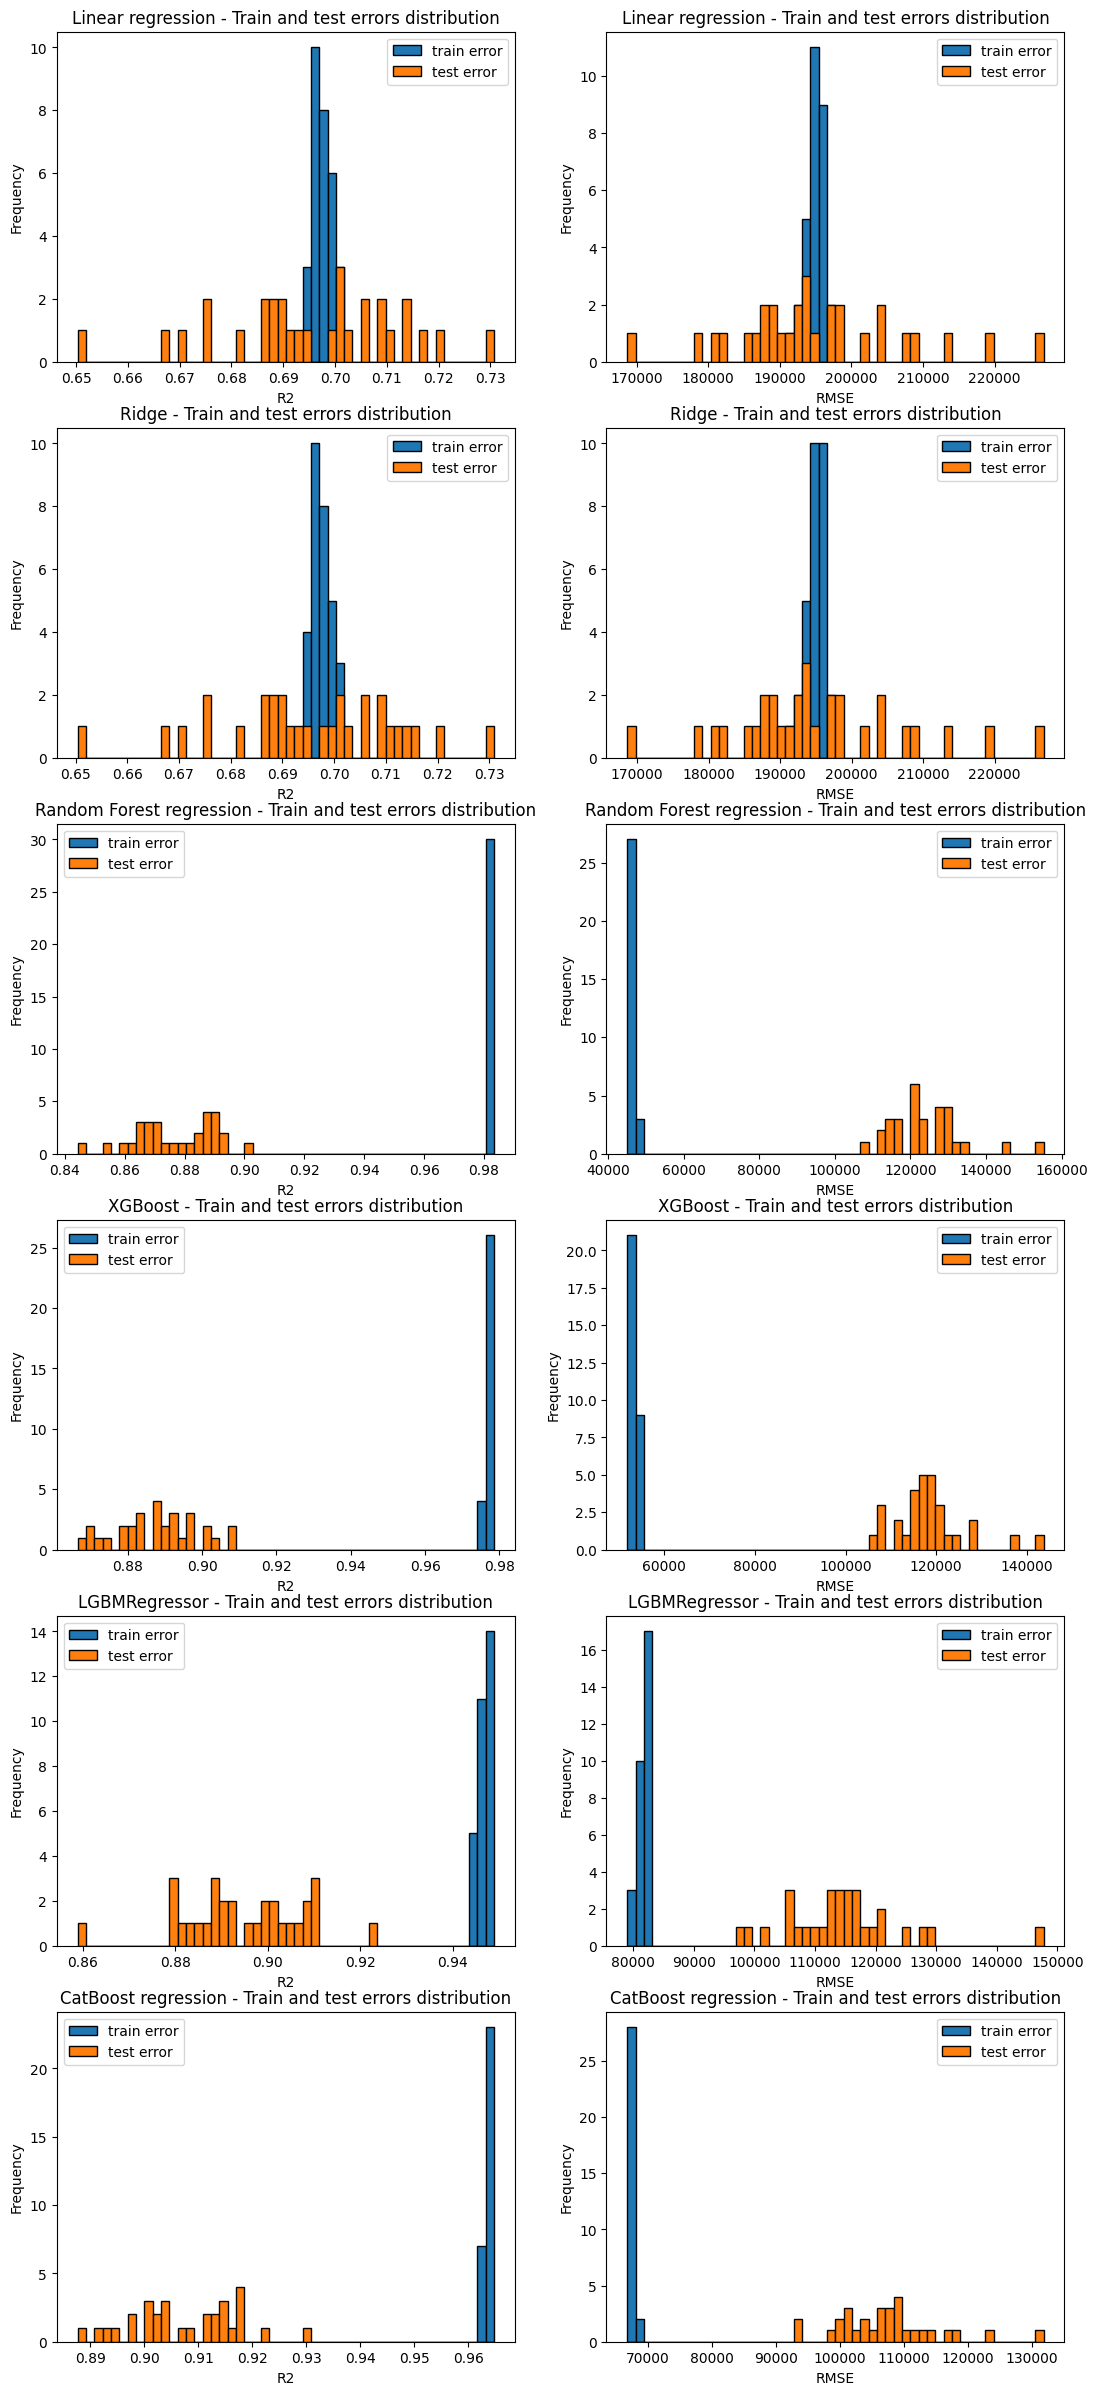

In [ ]:
def distribution_train_test_model(scores_dict):
    fig, axes = plt.subplots(nrows=len(scores_dict), ncols=2, figsize=(13, 5*len(scores_dict)))
    for i, (model_name, scores) in enumerate(scores_dict.items()):
        scores= pd.DataFrame(scores)
        scores_r2 = pd.DataFrame()
        scores_r2[["train error", "test error"]] = scores[["train_r2", "test_r2"]]

        scores_rmse = pd.DataFrame()
        scores_rmse[["train error", "test error"]] = scores[["train_rmse", "test_rmse"]]

        scores_r2.plot.hist(ax=axes[i,0], bins=50, edgecolor="black")
        axes[i,0].set_xlabel("R2")
        axes[i,0].set_title(f"{model_name} - Train and test errors distribution")

        scores_rmse.plot.hist(ax=axes[i,1], bins=50, edgecolor="black")
        axes[i,1].set_xlabel("RMSE")
        axes[i,1].set_title(f"{model_name} - Train and test errors distribution")

    plt.show()
distribution_train_test_model(feature_baseline)

In [ ]:
distribution_train_test_model(feature1)

Random Forest Learning Curve:

In [ ]:
max_depth = [1, 5, 10, 15, 20, 25]
train_scores, test_scores = validation_curve(
    RandomForestRegressor(), X, y, param_name = "max_depth", param_range = max_depth,
    cv = cv, scoring = "neg_mean_absolute_error", n_jobs = 2)
train_errors, test_errors = -train_scores, -test_scores

The validation curve can be divided into three zones:

For max_depth < 10, the decision tree is not suitable. The training error and therefore the testing error are both high. The model is too constrained and cannot capture much of the variability of the target variable.

The region around max_depth = 10 corresponds to the parameter for which the decision tree generalizes best. It is flexible enough to capture a fraction of the generalizing target variability, without memorizing all the target noise.

For max_depth > 10, the decision tree scales too much. The learning error becomes very small, while the testing error increases. In this region, models create decisions specifically for noisy samples, which impairs their ability to generalize to test data.

Note that for max_depth = 10, the model fits a bit too much since there is a gap between the training error and the testing error. It can also potentially be a little under-fit, as the training error is still far from zero (over $500,000), which means the model may still be too constrained to model interesting parts of the data. However, the test error is minimal, and that's what really matters. This is the best compromise we can achieve by simply adjusting this parameter.

In [ ]:
plt.plot(max_depth, train_errors.mean(axis=1), label="Training error")
plt.plot(max_depth, test_errors.mean(axis=1), label="Testing error")
plt.legend()

plt.xlabel("Maximum depth of decision tree")
plt.ylabel("Mean absolute error (k$)")
_ = plt.title("Validation curve for decision tree")

#### 5.2. Accuracy improvement

The *tune* function uses the Optuna library to tune a model's parameters by minimizing the root mean square error (RMSE) square value of the training data and validation data for each model. This optimization is performed using the Bayesian optimization method.

The objective function passed to Optuna must return the value of RMSE for each model trained with the parameters proposed by Optuna. Optuna then uses these results to find the best parameters to use to minimize the value of RMSE for the model.

In [ ]:
def tune(objective):
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=10)

    params = study.best_params
    best_score = study.best_value
    print(f"Best score: {best_score} \nOptimized parameters: {params}")
    return params

Optimization of selected algorithms


In [ ]:
def ridge_objective(trial):
    """
    """
    _alpha = trial.suggest_float("alpha", 0.1, 20)

    ridge = Ridge(alpha=_alpha, random_state=2023)

    pipeline = make_pipeline( baseline_transfomer, ridge) # Choisir la feature ici
    model = TransformedTargetRegressor(regressor=pipeline, transformer=MinMaxScaler())
    score = cross_val_score(
        model, X, y, cv=5, scoring="neg_root_mean_squared_error"
    ).mean()
    return score
tune(ridge_objective)

In [ ]:
def randomforest_objective(trial):
    _n_estimators = trial.suggest_int("n_estimators", 50, 200)
    _max_depth = trial.suggest_int("max_depth", 5, 15)
    _min_samp_split = trial.suggest_int("min_samples_split", 2, 10)
    _min_samples_leaf = trial.suggest_int("min_samples_leaf", 2, 10)
    _max_features = trial.suggest_int("max_features", 10, 50)

    rf = RandomForestRegressor(
        max_depth=_max_depth,
        min_samples_split=_min_samp_split,
        min_samples_leaf=_min_samples_leaf,
        max_features=_max_features,
        n_estimators=_n_estimators,
        n_jobs=-1,
        random_state=2023,
    )

    pipeline = make_pipeline( baseline_transfomer, rf) # Choisir la feature ici
    model = TransformedTargetRegressor(regressor=pipeline, transformer=MinMaxScaler())
    score = cross_val_score(
        model, X_train, y_train, cv=5, scoring="neg_root_mean_squared_error"
    ).mean()
    return score
# Best score: -126246.7397345615
# Optimized parameters: {'n_estimators': 192, 'max_depth': 15, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 15}
# {'n_estimators': 192,
#  'max_depth': 15,
#  'min_samples_split': 5,
#  'min_samples_leaf': 2,
#  'max_features': 15}
tune(randomforest_objective)

In [ ]:
def xgb_objective(trial):
    _n_estimators = trial.suggest_int("n_estimators", 50, 2000)
    _max_depth = trial.suggest_int("max_depth", 1, 20)
    _learning_rate = trial.suggest_float("learning_rate", 0.01, 1)
    _gamma = trial.suggest_float("gamma", 0.01, 1)
    _min_child_weight = trial.suggest_float("min_child_weight", 0.1, 10)
    _subsample = trial.suggest_float('subsample', 0.01, 1)
    _reg_alpha = trial.suggest_float('reg_alpha', 0.01, 10)
    _reg_lambda = trial.suggest_float('reg_lambda', 0.01, 10)

    xgbr = XGBRegressor(
        n_estimators=_n_estimators,
        max_depth=_max_depth,
        learning_rate=_learning_rate,
        gamma=_gamma,
        min_child_weight=_min_child_weight,
        subsample=_subsample,
        reg_alpha=_reg_alpha,
        reg_lambda=_reg_lambda,
        random_state=2023,
    )

    pipeline = make_pipeline( baseline_transfomer, xgbr) # Choisir la feature ici
    model = TransformedTargetRegressor(regressor=pipeline, transformer=MinMaxScaler())
    score = cross_val_score(
        model, X_train, y_train, cv=5, scoring="neg_root_mean_squared_error"
    ).mean()
    return score
#Trial 56 finished with value: -130666.78914147588 and parameters:
#{'n_estimators': 1923, 'max_depth': 8, 'learning_rate': 0.5441768830891188, 'gamma': 0.012699847284691094, 'min_child_weight': 3.4190014455330378, 'subsample': 0.8208619164939588, 'reg_alpha': 0.47183809102283264, 'reg_lambda': 6.158746067885835}. Best is trial 56 with value: -130666.78914147588.
tune(xgb_objective)

In [ ]:
import lightgbm as lgb

def lgb_objective(trial):
    _num_leaves = trial.suggest_int("num_leaves", 50, 100)
    _max_depth = trial.suggest_int("max_depth", 1, 20)
    _learning_rate = trial.suggest_float("learning_rate", 0.01, 1)
    _n_estimators = trial.suggest_int("n_estimators", 50, 2000)
    _min_child_weight = trial.suggest_float("min_child_weight", 0.1, 10)
    _reg_alpha = trial.suggest_float('reg_alpha', 0.01, 10)
    _reg_lambda = trial.suggest_float('reg_lambda', 0.01, 10)
    _subsample = trial.suggest_float('subsample', 0.01, 1)



    lgbr = lgb.LGBMRegressor(objective='regression',
                             num_leaves=_num_leaves,
                             max_depth=_max_depth,
                             learning_rate=_learning_rate,
                             n_estimators=_n_estimators,
                             min_child_weight=_min_child_weight,
                             subsample=_subsample,
                             reg_alpha=_reg_alpha,
                             reg_lambda=_reg_lambda,
                             random_state=2023,
    )


    pipeline = make_pipeline( baseline_transfomer, lgbr) # Choisir la feature ici
    model = TransformedTargetRegressor(regressor=pipeline, transformer=MinMaxScaler())
    score = cross_val_score(
        model, X_train, y_train, cv=5, scoring="neg_root_mean_squared_error"
    ).mean()
    return score
#Best score: -113612.75351554013
# Optimized parameters: {'num_leaves': 52, 'max_depth': 4, 'learning_rate': 0.072253747018493, 'n_estimators': 927, 'min_child_weight': 0.3638673001661791, 'reg_alpha': 0.024995849978417334, 'reg_lambda': 8.750628926778639, 'subsample': 0.4338177757587451}
# {'num_leaves': 52,
#  'max_depth': 4,
#  'learning_rate': 0.072253747018493,
#  'n_estimators': 927,
#  'min_child_weight': 0.3638673001661791,
#  'reg_alpha': 0.024995849978417334,
#  'reg_lambda': 8.750628926778639,
#  'subsample': 0.4338177757587451}
tune(lgb_objective)

In [ ]:
def ctb_objective(trial):

    params = {
        "iterations": trial.suggest_int("iterations", 100, 2000),
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.08),
        "depth": trial.suggest_int("depth", 3, 9),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 0.1, 10),
        "bagging_temperature": trial.suggest_float("bagging_temperature", 0, 1),
        "random_seed": 42,
        "loss_function": "RMSE",
        "eval_metric": "RMSE",
        "verbose": False
    }

    # initialize the model with the hyperparameters
    ctbr = CatBoostRegressor(**params)

    pipeline_test = make_pipeline( baseline_transfomer , ctbr)
    model = TransformedTargetRegressor(regressor=pipeline_test, transformer=MinMaxScaler())

    score = cross_val_score(
        model, X_train, y_train,  cv=5, scoring="neg_root_mean_squared_error"
    ).mean()
    return score

ctb_params = tune(ctb_objective)

### 6. Finalizing the model

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=105)
ctbr = CatBoostRegressor(depth=4,l2_leaf_reg=7,learning_rate= 0.1,logging_level='Silent')
#ctbr = CatBoostRegressor(**ctb_params)
pipeline_final = make_pipeline( baseline_transfomer , ctbr)
model = TransformedTargetRegressor(regressor=pipeline_final, transformer=MinMaxScaler())


Predictions on the validation dataset

In [ ]:
model.fit(X_train,y_train)
# predict the target on train and test data
predict_train = model.predict(X_train)
predict_test  = model.predict(X_test)

# Root Mean Squared Error on train and test date
print('RMSE on train data: ', mean_squared_error(y_train, predict_train)**(0.5))
print('RMSE on test data: ',  mean_squared_error(y_test, predict_test)**(0.5))

Results interpretation

In [ ]:
ctbr.fit(X_train, y_train)
ctbr.get_feature_importance(prettified=True)

Save the model for future use

In [ ]:
def predict_final(model):
  data_rendre = data_test.drop(['id','price','sqft_living15', 'sqft_lot15', 'Ech'], axis=1)
  data_rendre.loc[data_rendre["yr_renovated"] < 2000, "yr_renovated"] = 0
  data_rendre.loc[data_rendre["yr_renovated"] != 0, "yr_renovated"] = 1
  predict_data = model.predict(data_rendre)
  fichier_a_rendre = pd.read_csv(Path.cwd().joinpath("data").joinpath("Fichier_a_rendre.csv"),sep=";").drop(['price'], axis=1)
  fichier_a_rendre["price"] = predict_data
  return fichier_a_rendre

In [ ]:
data_predict_final = predict_final(ctbr)

In [ ]:
data_predict_final.to_csv("CTB_model_sampling.csv", index=False)

### 7. Model interpretation

In [ ]:
import shap

In [ ]:
explainer = shap.Explainer(ctbr)
shap_values = explainer(X_train)

# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[0])

### Bibliographie

- https://www.kaggle.com/code/alaasedeeq/object-oriented-programming-for-data-science

- https://www.kaggle.com/code/alexisbcook/data-leakage

- https://practicaldatascience.co.uk/machine-learning/how-to-add-feature-engineering-to-a-scikit-learn-pipeline

- https://towardsdatascience.com/why-you-shouldnt-use-pandas-get-dummies-for-machine-learning-e088a435beef

- https://towardsdatascience.com/2-ways-to-build-your-own-custom-scikit-learn-transformers-a8aeefbf8bf8

- https://scikit-learn.org/stable/modules/generated/sklearn.compose.TransformedTargetRegressor.html

- https://scikit-learn.org/stable/auto_examples/compose/plot_transformed_target.html#sphx-glr-auto-examples-compose-plot-transformed-target-py

- http://www.xavierdupre.fr/app/mlinsights/helpsphinx/notebooks/sklearn_transformed_target.html

- https://towardsdatascience.com/using-functiontransformer-and-pipeline-in-sklearn-to-predict-chardonnay-ratings-9b13fdd6c6fd